## Homework 7

**Submitted by : Tanvi Arora**   
**Section     : DS 7337 Natural Language Processing - 401**

<a id="top"></a>
### Contents

* <a href="#functionswebscrap">Function Definitions for Webscraping</a>
* <a href="#moviedata">Movie Data Collection</a>
* <a href="#movieselection">movie selection</a>
* <a href="#userreviewselection">User Reviews Selection for each movie</a>
* <a href="#functionscluster"> Help Functions for Clustering</a>
* <a href="#preprocess4clustering">Preprocess for clustering</a>
* <a href="#kmeansclustering">1 - KMeans Clustering</a>
* <a href="#kmeanscentroid2">2 - Cluster Centroids k=2</a>
* <a href="#kmeanscentroid5">2 - Cluster Centroids k=5</a>
* <a href="#kmeansclusteringpca">1 - KMeans Clustering on PCA ( k=3 ,5 )</a>
* <a href="#analysis">3 - Analysis</a>

In [170]:
import platform
print(platform.platform())

import os
print ("environment",os.environ['CONDA_DEFAULT_ENV'])

import sys
print("Python",sys.version)

import nltk
from nltk.tokenize import regexp_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
print("nltk",nltk.__version__)

#from nltk.tag.util import tuple2str

import numpy as np
print("numpy", numpy.__version__)

from bs4 import BeautifulSoup
import requests
#from __future__ import division, unicode_literals 
from urllib import request
from tabulate import tabulate
import pandas as pd

## for visualizations
import matplotlib.pyplot as plt


pd.set_option('display.max_rows',30)
import re
from random import randint

## spaCy library
import spacy
sp_nlp=spacy.load('en')

import string
import collections

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score


## ignore/suppress warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

Darwin-18.6.0-x86_64-i386-64bit
environment base
Python 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
nltk 3.4
numpy 1.16.1


### References :

http://brandonrose.org/clustering  
https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a  


<a id="functionswebscrap"></a>
<a href="#top">Back to Top</a>

### Function Definitions - webscraping

In [2]:
## call main URL
baseurl="https://www.imdb.com"
biographylink="https://www.imdb.com/search/title/?release_date=2010-01-01,2019-12-31&genres=biography&page=1"

## returns webpage content if web page accessible else None
def getSoup(url):
    grab_page = requests.get(url,timeout=5)
    if grab_page.status_code != 200:
        print("Error:page not found")
        return None
    else:
        #print("page found")
        return BeautifulSoup(grab_page.content, 'html5lib')

## basic beautiful soup read function 
def read_html(url):
    html = request.urlopen(url).read().decode('utf8')
    raw = BeautifulSoup(html, 'html.parser').get_text()
    tokens = word_tokenize(raw)
    text = nltk.Text(tokens)
    return text

## fetch main page data
def get_movie_home_container(searchurl):
    moviehome_soup=getSoup(searchurl)
    return moviehome_soup.find_all('div', class_ = "lister-item-content")

## fetch movie list from the main page data
## currently this function gets data from default or first page from search url
## this function returns a dataframe that contains list of movie names, individual movie links
## imdb ratings ( average of user ratings), metascores and # of votes that can be use for 
## further data analysis
def get_movielist_home(homecontainer):
    names=[]
    movielinks=[]
    imdb_ratings=[]
    metascores=[]
    votes=[]
    for container in homecontainer:
    # Look for movies with a Metascore
        if container.find('div', class_='inline-block ratings-metascore') is not None:
            names.append(container.h3.a.text)
            movielinks.append(baseurl+container.h3.a.attrs["href"])
            imdb_ratings.append(float(container.strong.text))
            metascores.append(float(container.find('span',class_='metascore').text))
            votes.append(container.find('span',attrs = {'name':'nv'})['data-value'])
        
        m_df=pd.DataFrame({'moviename':names,
                      'movielinks':movielinks,
                      'imdb_ratings':imdb_ratings,
                      'metascores':metascores,
                      'votes':votes})
    return m_df

## This function returns the main user review page from the individual movie link
def get_movie_user_review_link(movie_url):
    imovie_containers=[]
    imovie_soup=getSoup(movie_url)
    imovie_userreview_container = imovie_soup.find_all('div', class_ = "user-comments")
    #print(type(imovie_userreview_container))
    #print(len(imovie_userreview_container))
    return [baseurl+alink.attrs["href"] for alink in imovie_userreview_container[0].find_all('a') if re.findall(r"user reviews$",alink.text)]

## This function gets the cast and character list that can be further used to 
## build a custom lexicon for Proper Nouns
def get_movie_cast_charc_list(movie_url):
    imovie_soup=getSoup(movie_url)
    imovie_cast_container=imovie_soup.find_all('table', class_ = "cast_list")
    cast_list=[re.sub('\s+',' ',(cast.find('a').text).strip(' \n\t')) for cast in imovie_cast_container[0].find_all('td', class_=None)]
    character_list=[re.sub('\s+',' ',(cast.text).strip(' \n\t')) for cast in imovie_cast_container[0].find_all('td', class_="character")]
    return (cast_list,character_list)


## This function generates a list of 6 random numbers, 
## 3 in the range of 1 to 5 and 3 in the range of 6-10
def get_random_number_list(total,lownum,highnum):
    setOfNumbers = set()
    while len(setOfNumbers) < total/2:
        setOfNumbers.add(randint(lownum, round(highnum/2,0)))
    
    while len(setOfNumbers) < total:
        setOfNumbers.add(randint(round(highnum/2,0) , highnum))
                         
    return setOfNumbers
    
## This function returns a dataframe of individual user review links(permalink) and some
## additional information for each user review like review_date, user_rating , 
## user rating pointscale and user review title
## It also accepts number of reviews required per movie as input
def get_movie_user_reviews(movie_df,num_reviews_):
    m_ind=0
    num_reviews=num_reviews_
    movie_index=[]
    review_date=[]
    user_rating=[]
    user_pointscale=[]
    permalink=[]
    title=[]

    for m in movie_df["user_review_link"]:
        #print("review page :", m)
        m_ind=m_ind+1
        #print("movie# :", m_ind-1)
        n=0
        user_review_soup=getSoup(m[0])
        imovie_user_review_container=user_review_soup.find_all('div', class_="lister-item mode-detail imdb-user-review collapsable")
        #reviewpoints=[randint(1, 10) for i in range(0,num_reviews)]
        reviewpoints=get_random_number_list(num_reviews,1,10)
        #print(reviewpoints)
        for ur in imovie_user_review_container:
            #print(ur.find('a', class_='title').text)
            rating=[int(rating.text) for rating in ur.find_all('span', class_=None) if (rating.text.isnumeric() and rating.text is not None)]
            #print("rating: ",rating)
            if len(rating)!=0:
                if rating[0] in reviewpoints:

                    movie_index.append(m_ind-1)
                    user_rating.append(rating[0])
                    review_date.append(ur.find('span',class_="review-date").text)
                    user_pointscale.append(ur.find_all('span', class_='point-scale')[0].text)
                    #user_review.append(ur.find('div', class_=re.compile(r"show-more")).text)
                    permalink.append([ baseurl+link.attrs["href"] for link in ur.find_all('a') if link.text=="Permalink"][0])
                    title.append(ur.find('a', class_='title').text)
                    #print(ur.find('a', class_='title').text)
                    #print(ur.find('div', class_=re.compile(r"show-more")).text)
                    n=n+1
                    #print("====================")
                    reviewpoints.remove(rating[0])
                if n==num_reviews:
                    break
    


    user_review_df=pd.DataFrame({"movie#":movie_index,
                                "user_rating":user_rating,
                                "rating_point_scale":user_pointscale,
                                "review_date":review_date,
                                "permalink":permalink,
                                "title":title})
    return user_review_df

## based on user rating this function returns if review is positive(>=5) or negative(<5)
def get_user_rating_label(rating):
    if rating>=5:
        return "positive"
    else:
        return "negative"

## this function returns actual user review text and title from the individual user review link(permalink)
def get_user_review(user_review_url):
    imovie_name=[]
    ireview_title=[]
    iuser_review=[]
    ireview_soup=getSoup(user_review_url)
    ireview_container=ireview_soup.find_all('div', class_="lister-item-content")
    for review in ireview_container:
        imovie_name=review.find_all('div', class_="lister-item-header")[0].find_all('a')[0].text
        ireview_title=review.find('a', class_="title").text
        iuser_review=review.find('div', class_=re.compile(r"show-more")).text
    return imovie_name,ireview_title,iuser_review

## this function calls get_user_review function for the list of user_review links
def get_all_user_review(review_df):
    movie_name=[]
    review_title=[]
    user_review=[]
    for link in review_df["permalink"]:
        mname,rtitle,ureview=get_user_review(link)
        movie_name.append(mname)
        review_title.append(rtitle)
        user_review.append(ureview)
    return movie_name,review_title,user_review

## this function returns NP using spaCy library
def get_np_chunks(sentence):
    doc=sp_nlp(sentence)
    return [np.text for np in doc.noun_chunks]        

<a id="moviedata"></a>
<a href="#top">Back to Top</a>
### Movie Data Collection

**website** www.imdb.com  
**Genre** Biography

<a id="movieselection"></a>
<a href="#top">Back to Top</a>

### Movie Selection

In [3]:
## Call Main

moviehome_container=get_movie_home_container(biographylink)
print(type(moviehome_container))
print(len(moviehome_container))
movie_df=get_movielist_home(moviehome_container)

<class 'bs4.element.ResultSet'>
50


In [4]:
movie_df

,moviename,movielinks,imdb_ratings,metascores,votes
0,Skin,https://www.imdb.com/title/tt6043142/,6.8,58.0,3084
1,First Man,https://www.imdb.com/title/tt1213641/,7.3,84.0,127289
2,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,363177
3,Rocketman,https://www.imdb.com/title/tt2066051/,7.6,69.0,47118
4,"Extremely Wicked, Shockingly Evil and Vile",https://www.imdb.com/title/tt2481498/,6.7,52.0,47502
5,Green Book,https://www.imdb.com/title/tt6966692/,8.2,69.0,223811
6,The Current War,https://www.imdb.com/title/tt2140507/,6.1,44.0,1451
7,Tolkien,https://www.imdb.com/title/tt3361792/,6.9,48.0,7174
8,Breakthrough,https://www.imdb.com/title/tt7083526/,5.8,46.0,3457
9,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,8.2,75.0,1045450


In [5]:
## Get user review page for each movie
movie_df["user_review_link"]=movie_df.apply(lambda row : get_movie_user_review_link(row["movielinks"]), axis=1)
movie_df

,moviename,movielinks,imdb_ratings,metascores,votes,user_review_link
0,Skin,https://www.imdb.com/title/tt6043142/,6.8,58.0,3084,[https://www.imdb.com/title/tt6043142/reviews]
1,First Man,https://www.imdb.com/title/tt1213641/,7.3,84.0,127289,[https://www.imdb.com/title/tt1213641/reviews]
2,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,363177,[https://www.imdb.com/title/tt1727824/reviews]
3,Rocketman,https://www.imdb.com/title/tt2066051/,7.6,69.0,47118,[https://www.imdb.com/title/tt2066051/reviews]
4,"Extremely Wicked, Shockingly Evil and Vile",https://www.imdb.com/title/tt2481498/,6.7,52.0,47502,[https://www.imdb.com/title/tt2481498/reviews]
5,Green Book,https://www.imdb.com/title/tt6966692/,8.2,69.0,223811,[https://www.imdb.com/title/tt6966692/reviews]
6,The Current War,https://www.imdb.com/title/tt2140507/,6.1,44.0,1451,[https://www.imdb.com/title/tt2140507/reviews]
7,Tolkien,https://www.imdb.com/title/tt3361792/,6.9,48.0,7174,[https://www.imdb.com/title/tt3361792/reviews]
8,Breakthrough,https://www.imdb.com/title/tt7083526/,5.8,46.0,3457,[https://www.imdb.com/title/tt7083526/reviews]
9,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,8.2,75.0,1045450,[https://www.imdb.com/title/tt0993846/reviews]


<a id="userreviewselection"></a>
<a href="#top">Back to Top</a>

### User Reviews Selection for each movie

In [6]:
# get 5 random user reviews for each movie
user_review_df=get_movie_user_reviews(movie_df,10)
print(len(user_review_df))
print(user_review_df.head())

219
   movie#  user_rating rating_point_scale        review_date  \
0       0            6                /10       23 July 2019   
1       0            1                /10       24 July 2019   
2       0           10                /10  11 September 2018   
3       0            9                /10       25 June 2019   
4       0            8                /10       24 July 2019   

                                permalink  \
0  https://www.imdb.com/review/rw5013547/   
1  https://www.imdb.com/review/rw5016134/   
2  https://www.imdb.com/review/rw4333438/   
3  https://www.imdb.com/review/rw4958324/   
4  https://www.imdb.com/review/rw5015876/   

                                               title  
0   Not Oscar worthy and not cringeworthy, just a...  
1                        REAL STORY SO MUCH BETTER\n  
2                                  INCREDIBLE FILM\n  
3        I could have continued watching for hours\n  
4                  I thought it was a great watch.\n  


In [7]:

user_review_df["user_review_label"]=user_review_df["user_rating"].apply(get_user_rating_label)
user_review_df[["user_rating","user_review_label"]].head(7)

,user_rating,user_review_label
0,6,positive
1,1,negative
2,10,positive
3,9,positive
4,8,positive
5,4,negative
6,9,positive


<a id="userreview"></a>
<a href="#top">Back to Top</a>


### Main review text from each User link

In [8]:
usermovie,usertitle,userreview=get_all_user_review(user_review_df)

In [9]:
print(len(usermovie))
print(len(usertitle))
print(len(userreview))

219
219
219


<span style="color:blue">Total number of user reviews collected are 219</span>

In [10]:
user_review_df["user_movie_name"]=usermovie
user_review_df["user_review_title"]=usertitle
user_review_df["user_review"]=userreview
user_review_df[["user_movie_name","user_review_title","user_review"]].head()

,user_movie_name,user_review_title,user_review
0,Skin,"Not Oscar worthy and not cringeworthy, just a...",Some people have rated this a 1 star and other...
1,Skin,REAL STORY SO MUCH BETTER\n,"It is too bad Hollywood, once again, has to ch..."
2,Skin,INCREDIBLE FILM\n,Amazing film! It was an edge of your seat type...
3,Skin,I could have continued watching for hours\n,"I thought this film was incredible, a true sto..."
4,Skin,I thought it was a great watch.\n,I thought it was a great film to watch conside...


In [113]:
user_review_df[['user_review_label','user_rating']].groupby(by=['user_rating']).count()

,user_review_label
user_rating,
1,18
2,15
3,9
4,17
5,18
6,21
7,24
8,32
9,33


Although a random selection of user rating was chosen, to include almost equal number of reviews in the range 0,4 and 5,10 There are more reviews selected in the latter group. This could be due to the way data is collected. Web scraping is performed on only the first/default user reviews page i.e. top 50 and possibility there are less reviews with lower ratings in the first page. OR movie could actually be having more good ratings. Overall the results in this project will vary if performed on higher number of ratings.

<a id="functionscluster"></a>
<a href="#top">Back to Top</a>

### Help functions - Clustering

In [59]:
## This function will clean the text of punctuations and generate tokens.
## It has an additiona option to perform Stemming. 
## Stemming did not yield good results as some of the words lost their meaning, so 
## approach chosen was to go without stemming

def process_text(text, stem=False):
    text=text.translate(str.maketrans('','', string.punctuation))
    tokens=word_tokenize(text)
    if stem:
        stemmer = PorterStemmer()
        tokens=[stemmer.stem(t) for t in tokens]
    return tokens

## This function performs TFIDF vectorization on the list of user reviews
## returns tfidf matrix and feature names
def get_tfidvector(texts):
    vectorizer = TfidfVectorizer(tokenizer=process_text,stop_words=sp_nlp.Defaults.stop_words,max_df=0.5,min_df =0.1, lowercase=True)
    tfidf_matrix=vectorizer.fit_transform(texts)
    return tfidf_matrix,vectorizer.get_feature_names()

## This function creates Kmeans clusters
## by default number of clusters created is 2
## number of clusters required can be provided as input
## returns the clusters directly
def get_clusters(tfidf_mat,clusters=2):
    km_model=KMeans(n_clusters=clusters)
    km_model.fit(tfidf_mat)
    clusters=km_model.labels_.tolist()
    #print(clusters)
    return clusters

## This function creates Kmeans clusters
## by default number of clusters created is 2
## number of clusters required can be provided as input
## returns kmeans model so it can be further used 
def get_kmeans(tfidf_mat,clusters=2):
    km_model=KMeans(n_clusters=clusters)
    km_model.fit(tfidf_mat)
    return km_model



#from __future__ import print_function
def get_centroid_values(model,vocab_frame,num_clusters=2):
    print("For Cluster size :",num_clusters )
    print("Top Terms per cluster:")
    print()
#num_clusters=3

    order_centroids = model.cluster_centers_.argsort()[:,::-1]
    print(order_centroids)

    for i in range(num_clusters):
        print("Cluster %d ,words:" % i,end='')
    
        for ind in order_centroids[i, :10]:
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8','ignore'), end=',')
        print()
        print()
    
    #print("Cluster %d ,reviews:" % i, end='')
    #for review in user_reviews_clust_df.ix[i]['user_review_tokens']:
    #    print(' %s,' % review, end='')
    print()
    print()

<a id="preprocess4clustering"></a>
<a href="#top">Back to Top</a>
### Pre-process user reviews for Clustering

#### Tokenize user reviews

In [14]:
user_review_df["user_review_tokens"]=user_review_df.apply(lambda row : process_text(row["user_review"],False), axis=1)
user_review_df["user_review_tokens"]

0      [Some, people, have, rated, this, a, 1, star, ...
1      [It, is, too, bad, Hollywood, once, again, has...
2      [Amazing, film, It, was, an, edge, of, your, s...
3      [I, thought, this, film, was, incredible, a, t...
4      [I, thought, it, was, a, great, film, to, watc...
5      [The, fact, this, is, based, on, a, true, stor...
6      [I, now, laugh, when, I, reread, some, of, the...
7      [The, attempt, to, make, it, all, feel, dated,...
8      [I, saw, this, movie, at, a, sneak, preview, a...
9      [Came, watching, this, with, high, expectation...
10     [The, opening, scene, will, take, your, breath...
11     [Boring, and, selfimportant, The, photography,...
12     [A, really, badly, mad, film, has, no, enterta...
13     [With, no, disrespect, to, the, director, here...
14     [This, movie, is, a, must, see, for, any, musi...
                             ...                        
204    [My, wife, and, I, both, professionals, about,...
205    [Hubby, and, I, are, Can

#### Generate vocabulary of all words in the user reviews to be used later for display

In [15]:
totalvocab_tokenized=[]
for t in user_review_df["user_review_tokens"]:
    totalvocab_tokenized.extend(t)

vf=list(set(totalvocab_tokenized))
vocab_frame = pd.DataFrame({'words': vf}, index = vf)
print(vocab_frame.head())
print()
print("length of vocabulary :",len(vocab_frame))

                   words
justifying    justifying
feminine        feminine
generations  generations
engineering  engineering
soso                soso

length of vocabulary : 9010


#### TFIDF Vectorization

Next we will convert all user reviews to wordvectors using tfidf vectorization

In [19]:
user_reviews_tfidf, terms=get_tfidvector(user_review_df["user_review"])

print("shape of the tfidf vector")
print("-------------------------")
print(user_reviews_tfidf.shape)
print()
print()

print("feature names used in TFIDF vector")
print("----------------------------------")
print(terms)
print()
print()
#cluster = cluster_texts(user_review_df["user_review"])

shape of the tfidf vector
-------------------------
(219, 90)


feature names used in TFIDF vector
----------------------------------
['acting', 'actors', 'actually', 'audience', 'bad', 'based', 'best', 'better', 'big', 'bit', 'cast', 'character', 'characters', 'didnt', 'directed', 'director', 'doesnt', 'dont', 'end', 'entertaining', 'especially', 'events', 'excellent', 'fact', 'family', 'fan', 'feel', 'felt', 'films', 'find', 'given', 'going', 'good', 'got', 'great', 'having', 'history', 'im', 'interesting', 'isnt', 'job', 'kind', 'know', 'left', 'let', 'life', 'like', 'little', 'long', 'look', 'lot', 'love', 'makes', 'man', 'moments', 'movies', 'music', 'new', 'people', 'performance', 'performances', 'point', 'real', 'right', 'role', 'saw', 'scene', 'scenes', 'screen', 'script', 'seen', 'sure', 'takes', 'thats', 'theres', 'thing', 'things', 'think', 'thought', 'time', 'times', 'true', 'want', 'wasnt', 'watch', 'watching', 'way', 'work', 'world', 'years']




/Users/tanviarora/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'll', 'm', 'n', 'nt', 's', 't', 've', '‘', '’'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<a id="kmeansclustering"></a>
<a href="#top">Back to Top</a>
## KMeans Clustering

KMeans Clustering is an unsupervised learning algorithm that allows to identify similar groups or patterns in our dataset. For the user reviews collected, I chose to go with KMeans clustering and not Hierarchical Clustering method.
Using the information on data collected, i.e. from a single genre of Bibliography I am not expecting a hierarchy . I want to visualize if there is a pattern in the user reviews.

Since KMeans cannot be performed on text, I have already converted user reviews using TFIDF ( Term Frequency-Inverse Document Frequency to vector of numbers. 

### Create default clusters ( number of clusters = 2)

In [98]:
user_reviews_clust2_df=user_review_df
user_reviews_clust2_df["cluster_label"]=get_clusters(user_reviews_tfidf)
print("size of dataframe :",len(user_reviews_clust2_df))
print()

user_reviews_clust2_df.head()


size of dataframe : 219



,movie#,user_rating,rating_point_scale,review_date,permalink,title,user_review_label,user_movie_name,user_review_title,user_review,user_review_tokens,cluster_label
cluster_label,,,,,,,,,,,,
1,0,6,/10,23 July 2019,https://www.imdb.com/review/rw5013547/,"Not Oscar worthy and not cringeworthy, just a...",positive,Skin,"Not Oscar worthy and not cringeworthy, just a...",Some people have rated this a 1 star and other...,"[Some, people, have, rated, this, a, 1, star, ...",0
1,0,1,/10,24 July 2019,https://www.imdb.com/review/rw5016134/,REAL STORY SO MUCH BETTER\n,negative,Skin,REAL STORY SO MUCH BETTER\n,"It is too bad Hollywood, once again, has to ch...","[It, is, too, bad, Hollywood, once, again, has...",0
3,0,10,/10,11 September 2018,https://www.imdb.com/review/rw4333438/,INCREDIBLE FILM\n,positive,Skin,INCREDIBLE FILM\n,Amazing film! It was an edge of your seat type...,"[Amazing, film, It, was, an, edge, of, your, s...",1
0,0,9,/10,25 June 2019,https://www.imdb.com/review/rw4958324/,I could have continued watching for hours\n,positive,Skin,I could have continued watching for hours\n,"I thought this film was incredible, a true sto...","[I, thought, this, film, was, incredible, a, t...",0
4,0,8,/10,24 July 2019,https://www.imdb.com/review/rw5015876/,I thought it was a great watch.\n,positive,Skin,I thought it was a great watch.\n,I thought it was a great film to watch conside...,"[I, thought, it, was, a, great, film, to, watc...",0


In [111]:
user_reviews_clust2_df.index.name=None
user_reviews_clust2_df[['user_review_label','cluster_label','user_rating']].groupby(by=['user_review_label','cluster_label']).count()

user_rating
user_review_label cluster_label             
negative          0                       37
                  1                       22
positive          0                       85
                  1                       75

My default instict was to choose cluster size = 2. Based on user ratings we have 2 groups of positive and negative reviews. Idea is to see if the clusters created for user reviews  have any similarity to the groups created based on user rating. From above output, there are almost equal number of reviews of both cluster labels 0 and 1 in the the review label positive and negative. So it looks like user rating groups are not matching the cluster labels based on user reviews or in simple terms , there is overlap of user review patterns in both positive and negative user reviews

In [114]:
#user_reviews_clust2_df.set_index('cluster_label',inplace=True)
model2=get_kmeans(user_reviews_tfidf)
clusters2=model2.labels_.tolist()
print(clusters2)

[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]


In [115]:
get_centroid_values(model2,vocab_frame)

For Cluster size : 2
Top Terms per cluster:

[[46 13 79 17 32 34 84 45 77 56 42  0 58  1 48 62 65  4 61 27 37 26 55 41
  67 83 78 33 51 24 47 82 30 59 18 25 44 31  9 76 15 50 71  7 38  6 12 80
  40 57 85 74 43 21 54 75 87 86 49 11 70 66 89 10 29 35 39 73  2 53 16 64
  20 23 69 19 81 52 63 88 28 36  8  3  5 14 68 60 22 72]
 [81 12 28 53 58 11 36 46  5 32  6 86 34 62 88  3 79 10 60 52 66 22 47 72
  59 45 87 70  7 67  8 26 73 16  9 74 23 84 64 20 15 54 68 63 29 85 89 19
   2 80 24 69 43 51 31 37 35 78 27 14 82 42 57  1 21 61 50 76  0 18  4 65
  77 75 71 55 39 17 49 25 41 33 44 38 40 48 83 30 56 13]]
Cluster 0 ,words: b'like', b'didnt', b'time', b'dont', b'good', b'great', b'watch', b'life', b'think', b'music',

Cluster 1 ,words: b'true', b'characters', b'films', b'man', b'people', b'character', b'history', b'like', b'based', b'good',





<a id="kmeanscentroid2"></a>
<a href="#top">Back to Top</a>

Selecting the top features of cluster size = 2, cluster 0 seems to have reviews that are movie being good while cluster 1 seems to talk about characters being great. Although there is not very distinct seperation as top features from both the clusters look positive and the reviews seem to be separated on the content , whether it is about the movie or the character

### Cluster size=5

Increasing the cluster size to 5, hoping to get more distinct features 

In [117]:
num_clusters=5
user_reviews_clust5_df=user_review_df
user_reviews_clust5_df["cluster_label"]=get_clusters(user_reviews_tfidf,num_clusters)
user_reviews_clust5_df.head()

,movie#,user_rating,rating_point_scale,review_date,permalink,title,user_review_label,user_movie_name,user_review_title,user_review,user_review_tokens,cluster_label
1,0,6,/10,23 July 2019,https://www.imdb.com/review/rw5013547/,"Not Oscar worthy and not cringeworthy, just a...",positive,Skin,"Not Oscar worthy and not cringeworthy, just a...",Some people have rated this a 1 star and other...,"[Some, people, have, rated, this, a, 1, star, ...",2
1,0,1,/10,24 July 2019,https://www.imdb.com/review/rw5016134/,REAL STORY SO MUCH BETTER\n,negative,Skin,REAL STORY SO MUCH BETTER\n,"It is too bad Hollywood, once again, has to ch...","[It, is, too, bad, Hollywood, once, again, has...",3
3,0,10,/10,11 September 2018,https://www.imdb.com/review/rw4333438/,INCREDIBLE FILM\n,positive,Skin,INCREDIBLE FILM\n,Amazing film! It was an edge of your seat type...,"[Amazing, film, It, was, an, edge, of, your, s...",0
0,0,9,/10,25 June 2019,https://www.imdb.com/review/rw4958324/,I could have continued watching for hours\n,positive,Skin,I could have continued watching for hours\n,"I thought this film was incredible, a true sto...","[I, thought, this, film, was, incredible, a, t...",4
4,0,8,/10,24 July 2019,https://www.imdb.com/review/rw5015876/,I thought it was a great watch.\n,positive,Skin,I thought it was a great watch.\n,I thought it was a great film to watch conside...,"[I, thought, it, was, a, great, film, to, watc...",0


In [118]:
user_reviews_clust5_df.index.name=None
user_reviews_clust5_df[['user_review_label','cluster_label','user_rating']].groupby(by=['user_review_label','cluster_label']).count()

user_rating
user_review_label cluster_label             
negative          0                        7
                  1                        4
                  2                       19
                  3                       14
                  4                       15
positive          0                       10
                  1                       39
                  2                       59
                  3                       20
                  4                       32

Above group does not make a lot of sense. There are less ratings in the cluster labels 0 and 1 for negative user reviews. However for positive user reviews, there are comparatively less number of reviews in clusters 0 and 3. Still not very distinct. 

In [32]:
user_reviews_clust5_df.set_index('cluster_label',inplace=True)
user_reviews_clust5_df.groupby(by="cluster_label")

In [36]:
model5=get_kmeans(user_reviews_tfidf,num_clusters)
clusters5=model5.labels_.tolist()
print(clusters5)

[1, 0, 4, 4, 1, 4, 3, 1, 4, 1, 2, 0, 0, 4, 1, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 0, 4, 0, 2, 2, 1, 4, 2, 0, 1, 2, 2, 4, 3, 3, 1, 4, 2, 1, 1, 2, 4, 1, 2, 2, 2, 4, 1, 2, 1, 2, 4, 4, 2, 1, 2, 3, 2, 4, 1, 3, 3, 3, 4, 3, 2, 4, 2, 2, 4, 0, 4, 3, 3, 2, 2, 0, 4, 1, 4, 1, 4, 4, 0, 2, 0, 1, 1, 3, 4, 1, 1, 1, 1, 1, 2, 2, 2, 1, 4, 4, 4, 4, 2, 0, 4, 4, 3, 3, 1, 3, 3, 1, 0, 1, 1, 1, 0, 3, 3, 4, 1, 4, 3, 2, 3, 3, 4, 4, 4, 3, 3, 1, 3, 0, 4, 4, 1, 4, 4, 3, 3, 3, 4, 1, 3, 1, 4, 3, 3, 2, 2, 4, 2, 4, 3, 2, 4, 3, 4, 4, 2, 1, 1, 4, 3, 4, 3, 3, 2, 2, 4, 3, 4, 1, 4, 4, 4, 3, 3, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 4, 4, 1, 2, 1, 2]


In [38]:
get_centroid_values(model5,vocab_frame,5)

For Cluster size : 5
Top Terms per cluster:

[[62 52 51 12 13 45  1 56 34  4 46 67  0 11 36 27 49  8 70 31 86 58 73 83
  24 74 48 80 32  2 88 85 23 63  7 78 41 57 79 66 19 30 33 18 65  5 37 53
  26 75 21 17 84  6 25 10 22  9 14  3 20 15 16 89 28 29 87 82 81 77 76 72
  71 69 68 64 61 60 59 55 54 50 47 43 42 40 39 38 35 44]
 [34  0 84 56 46  9 13 43 48 58 65 26  4 41 54 83 55 78 12 82 47 57 45 61
  27 28 67 20 42 59 33 85 25 79 18 70 86  1 77 69 38 62 17 21  7 89 87 19
  80  2 22 37 64 16 75  5 49 32 44  6 53 66 39 60 50 29 30 24 73 51  3 72
  35 10 71 36 63 23 40 11 81 74 31  8 88 14 68 76 15 52]
 [32 17 77 58 42 46 45 61 24 12 15 66 31 13  1 60 26 44 76 82 84  6 67 40
  27 65  4 86 88 79 47 62 37  9 55 25 38 70 75 59  2 23 51 29 50 80 30 16
   3 78  0 22 54 11 10 14 18 56 20 68 85 71  5 83 34 52 73 74 57  7 36 69
  35 39 41 64 21 87  8 63 43 53 28 48 49 33 19 81 89 72]
 [79 53 46 11 74 84 89 28 34 47 12 72 86 87 45 59 88 32 16 23 50  3 58 85
  48 80 71 35 20 15 33 68 60 37 22 43 54 55 

<a id="kmeanscentroid5"></a>
<a href="#top">Back to Top</a>

Lets look at the top features of the 5 clusters. Again all good words but there can be some seperation on the type of user reviews.

Cluster 0 : talks about characters and   music , terms like great   
Cluster 1 : talks about acting and also  about music , terms like great   
Cluster 2 : family characters , , terms like good   
Cluster 3 : talks about characters and film , terms like little   
Cluster 4 : talks about big , films and role  

Semantically this looks little difficult to identify or separate out the clusters. It could because of the small user review dataset that is skewed towards higher ratings meaning good reviews. Clusters look based on what the good reviews are about - characters, movie or music ?

<a id="kmeansclusteringpca"></a>
<a href="#top">Back to Top</a>
## KMeans on PCA components

Since I did not find very distinct features, I will plot the user reviews by converting the TFIDF vectors to 2-D values using PCA ( Principal Component Analysis ) so that I can plot the user reviews and the clusters

In [120]:


tfidf_norm = normalize(user_reviews_tfidf)
tfidf_user_reviews_array = tfidf_norm.toarray()
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tfidf_user_reviews_array)

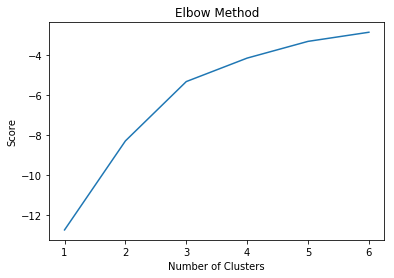

In [62]:
number_clusters = range(1,7)
score = [get_kmeans(Y_sklearn,i).score(Y_sklearn) for i in number_clusters]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Although there is not a very straight line, the curve tends to flatten after number of cluster=5. But it reduces a lot at cluster size = 3. Next lets apply KMeans on number of clusters size 3 and 5 and plot the data for comparison

In [160]:
model3_pca=get_kmeans(Y_sklearn,3)
clusters3_pca=model3_pca.labels_.tolist()
centers3_pca = model3_pca.cluster_centers_


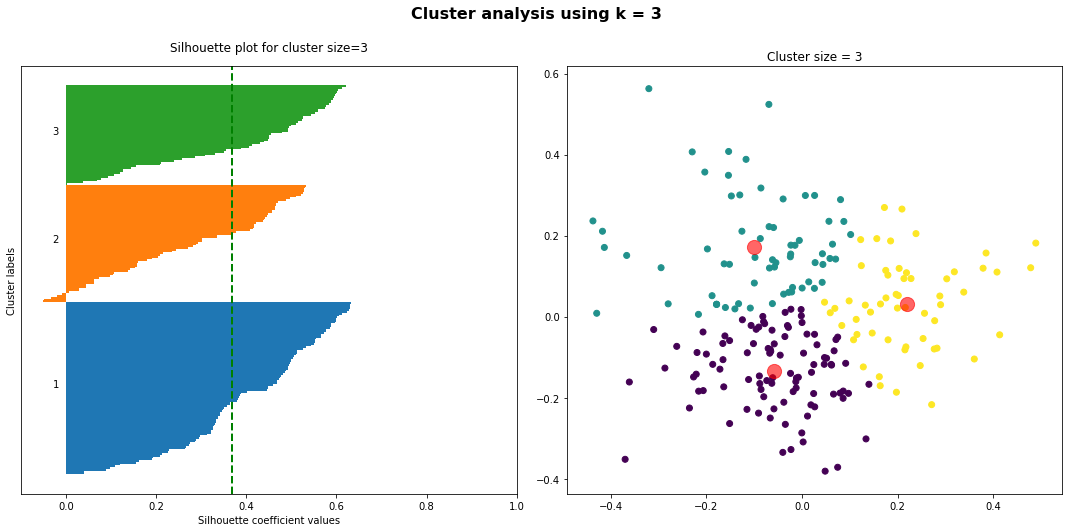

In [171]:
clusters3=pd.DataFrame({"cluster_label":clusters3_pca})
# Get silhouette samples
silhouette_vals3 = silhouette_samples(Y_sklearn, clusters3_pca)

# Silhouette plot
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(15,7)
y_ticks = []
y_lower, y_upper = 0,0


for i,cluster in enumerate(np.unique(clusters3)):
    
    cluster_silhouette_vals3 = silhouette_vals3[clusters3_pca == cluster]
    cluster_silhouette_vals3.sort()
    y_upper += len(cluster_silhouette_vals3)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals3, edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals3)

# Get the average silhouette score and plot it
avg_score3 = np.mean(silhouette_vals3)
ax1.axvline(avg_score3, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')
ax1.set_title('Silhouette plot for cluster size=3', y=1.02)

ax2.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=clusters3_pca , cmap='viridis')
ax2.set_title('Cluster size = 3')
ax2.scatter(centers3_pca[:,0],centers3_pca[:,1], c='red' , s=200 , alpha = 0.6)
    
plt.tight_layout()
plt.suptitle(f'Cluster analysis using k = 3',fontsize=16, fontweight='semibold', y=1.05);

Cluster size = 3, looks quiet good. We do not see overlaps. However we do see few outliers w.r.t centroids as the points are further. Maybe this would look better id cluster size is increased.

Average Silhouette score is approx 0.36 and all clusters have a score <=0.6
Cluster 1 seems to be the widest suggesting more data points within that cluster. Other 2 clusters look of approx similar sizes

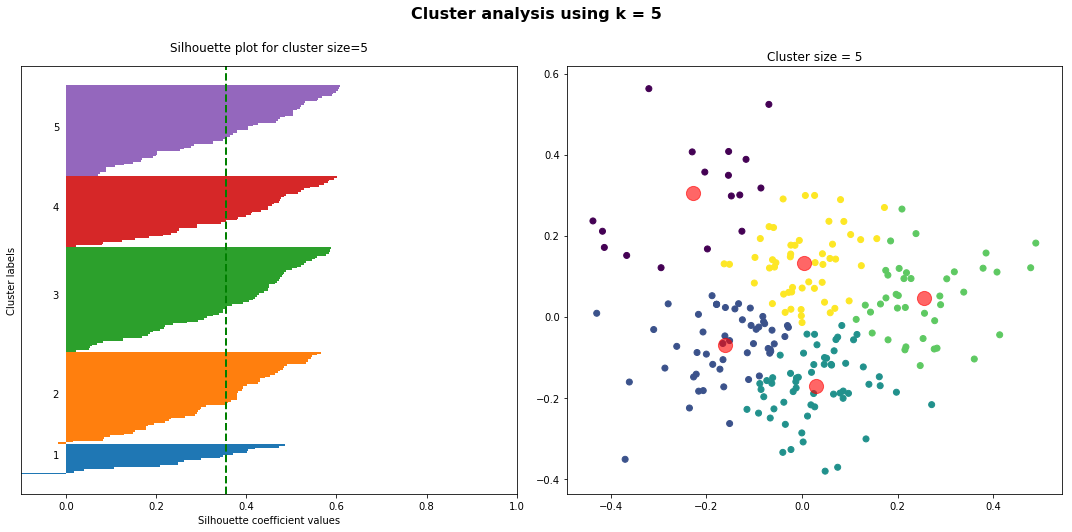

In [172]:
clusters5=pd.DataFrame({"cluster_label":clusters5_pca})
# Get silhouette samples
silhouette_vals5 = silhouette_samples(Y_sklearn, clusters5_pca)

# Silhouette plot
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(15,7)
y_ticks = []
y_lower, y_upper = 0,0


for i,cluster in enumerate(np.unique(clusters5)):
    
    cluster_silhouette_vals5 = silhouette_vals5[clusters5_pca == cluster]
    cluster_silhouette_vals5.sort()
    y_upper += len(cluster_silhouette_vals5)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals5, edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals5)

# Get the average silhouette score and plot it
avg_score5 = np.mean(silhouette_vals5)
ax1.axvline(avg_score5, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')
ax1.set_title('Silhouette plot for cluster size=5', y=1.02);
    
ax2.set_title('Cluster size = 5')
ax2.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=clusters5_pca , cmap='viridis')
ax2.scatter(centers5_pca[:,0],centers5_pca[:,1], c='red' , s=200 , alpha = 0.6)

plt.tight_layout()
plt.suptitle(f'Cluster analysis using k = 5',fontsize=16, fontweight='semibold', y=1.05);

Cluster size = 5, takes care of the outliers seen in the cluster size=3. It looks better ,maybe not the best but still looks optimum.  
Average Silhouette score is approx 0.36 and all clusters have a score <=0.6
Cluster 3 seems to be the widest suggesting more data points within that cluster
Cluster 1 looks to be the smallest cluster.

<a id="analysis"></a>
<a href="#top">Back to Top</a>
### Analysis

For K-Means clustering we want to identify how much centered the centroids are. From the cluster visualizations , cluster size of 5 i.e. with 5 centroids looks optimal as the outliers are not very distant from the centroids. In this particular case, Kmeans with 5 centroids looks to be a better choice. 
Since these are almost similar, it is also better to look at the Silhouette scores, since that would give number to the measure. Average silhouette score for both cluster sizes 3 and 5 look almost same and are < 0.5 , which is threshold to identify a good cluster. Both the clusters have few negative scores so overall for this dataset, either of cluster size 3 or 5 would do good. 